In [218]:
import time
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error

%matplotlib inline

### Loading the Book Ratings Dataset

In [219]:
ratings = pd.read_csv('../raw-data/BX-Book-Ratings.csv', encoding='iso-8859-1', sep = ';')
ratings.columns = ['user_id', 'isbn', 'book_rating']

In [220]:
print(ratings.dtypes)
print()
print(ratings.head())
print()
print("Data Points :", ratings.shape[0])

user_id         int64
isbn           object
book_rating     int64
dtype: object

   user_id        isbn  book_rating
0   276725  034545104X            0
1   276726  0155061224            5
2   276727  0446520802            0
3   276729  052165615X            3
4   276729  0521795028            6

Data Points : 1149780


### Loading the Books Dataset

In [221]:
books = pd.read_csv('../raw-data/BX-Books.csv', sep=';', encoding = 'iso-8859-1', dtype =str)
del books['Image-URL-L']
del books['Image-URL-M']
del books['Image-URL-S']
del books['Book-Author']
del books['Publisher']

Some Books don't have unique ISBN, creating a 1:1 maping between books-title and ISBN

In [222]:
print('Number of Books == Number of ISBN ? ', books["Book-Title"].nunique() == books["ISBN"].nunique())
book_dict = books[["Book-Title","ISBN"]].set_index("Book-Title").to_dict()["ISBN"]
books['new_isbn'] = books["Book-Title"].apply(lambda x: book_dict[x])
print('Number of Books == Number of ISBN ? ', books["Book-Title"].nunique() == books["new_isbn"].nunique())

Number of Books == Number of ISBN ?  False
Number of Books == Number of ISBN ?  True


In [223]:
books['isbn'] = books['new_isbn']

del books['ISBN']
del books['new_isbn']

In [224]:
books.shape

(271379, 3)

### Data Preparation/ Cleaning <br>

Removing ratings equal to zero, since Book Crossing Dataset has rating scale from 1-10. Taking Inner Join with books dataframe to maintain books whose details exist.

In [225]:
newdf = ratings[ratings.book_rating>0]
joined = books.merge(newdf, on ='isbn')
print(joined.shape)

(293111, 5)


In [226]:
rows = joined.user_id.unique()
cols = joined['Book-Title'].unique()
print(joined.user_id.nunique(), joined.isbn.nunique())

52097 129168


In [227]:
print("Sparsity :", 100 - (joined.shape[0]/(joined.user_id.nunique()* joined.isbn.nunique())))

Sparsity : 99.9999564423474


In [228]:
data1 = pd.read_csv('../clean-data/ratings_Books.csv', )

In [229]:
data1.columns = ['user_id', 'isbn', 'book_rating', 'timestamp']

In [230]:
rows = data1.user_id.unique()
cols = data1.isbn.unique()
print(data1.user_id.nunique(), data1.isbn.nunique())
print("Sparsity :", 100 - (data1.shape[0]/(data1.user_id.nunique()* data1.isbn.nunique())))

8026324 2330066
Sparsity : 99.99999879652889


In [232]:
data1 = data1[['user_id', 'isbn', 'book_rating']]

In [233]:
data1.shape

(22507154, 3)

In [234]:
data2 = joined[['user_id', 'isbn', 'book_rating']]

In [235]:
data2.book_rating = data2.book_rating / 2.0

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [236]:
data2.shape

(293111, 3)

In [237]:
data2 = data2.drop_duplicates()

In [238]:
data2.shape

(261676, 3)

In [239]:
data3 = pd.concat((data1, data2))

In [240]:
data3.shape

(22768830, 3)

In [241]:
temp = data3[data3['isbn'].isin(data3['isbn'].value_counts()[data3['isbn'].value_counts()>50].index)]
# print(len(temp.user_id.unique()))
# print(len(temp.isbn.unique()))
temp1 = temp[temp['user_id'].isin(temp['user_id'].value_counts()[temp['user_id'].value_counts()>49].index)]
# print(len(temp1.user_id.unique()))
# print(len(temp1.isbn.unique()))
temp2 = temp1[temp1['isbn'].isin(temp1['isbn'].value_counts()[temp1['isbn'].value_counts()>53].index)]
print(len(temp2.user_id.unique()))
print(len(temp2.isbn.unique()))

12053
4959


In [242]:
print(temp2.groupby(['user_id']).count()['book_rating'].mean())
print(temp2.groupby(['isbn']).count()['book_rating'].mean())

39.0565834232
94.9282113329


# Algo 1: Memory Based Algorithm : Item-Item CF Algorithm

Since average number of books rated by an user was around 3.3, we decided to use item-item CF as our memory based algorithm. Our implementation of item-item algorithm is below:

In [243]:
data = temp2
rows = data.user_id.unique()
cols = data.isbn.unique()
print(data.user_id.nunique(), data.isbn.nunique())
data = data[['user_id', 'isbn', 'book_rating']]
data.to_csv('Combine.csv')

12053 4959


In [244]:
print("Sparsity :", 100 - (data.shape[0]/(len(cols)*len(rows)) * 100))

Sparsity : 99.21241009430905


In [245]:
idict  = dict(zip(cols, range(len(cols))))
udict = dict(zip(rows, range(len(rows))))

data.user_id = [
    udict[i] for i in data.user_id
]
data['isbn'] = [
    idict[i] for i in data['isbn']
]

nmat = data.as_matrix()


In [246]:
nmat = nmat.astype(int)
nmat.shape

(470749, 3)

#### Function for Evaluation Metrics: MAE and RMSE

In [247]:
def rmse(ypred, ytrue):
    ypred = ypred[ytrue.nonzero()].flatten()
    ytrue = ytrue[ytrue.nonzero()].flatten()
    return np.sqrt(mean_squared_error(ypred, ytrue))

def mae(ypred, ytrue):
    ypred = ypred[ytrue.nonzero()].flatten()
    ytrue = ytrue[ytrue.nonzero()].flatten()
    return mean_absolute_error(ypred, ytrue)

Our Naive Baseline for any user i, item j prediction is to assign it with (sum of mean rating given by user i (umean[i]), mean rating received by item j (imean[j]) substracting average rating over entire dataset. (amean)) <br><br>
-------------- Naive Baseline ---------------


In [248]:
def predict_naive(user, item):
    prediction = imean1[item] + umean1[user] - amean1
    return prediction

In [249]:
x1, x2 = train_test_split(nmat, test_size = 0.2, random_state =42)
naive = np.zeros((len(rows),len(cols)))
for row in x1:
    naive[row[0], row[1]] = row[2]

predictions = []
targets = []

amean1 = np.mean(naive[naive!=0])
umean1 = sum(naive.T) / sum((naive!=0).T)
imean1 = sum(naive) / sum((naive!=0))

umean1 = np.where(np.isnan(umean1), amean1, umean1)
imean1 = np.where(np.isnan(imean1), amean1, imean1)


print('Naive---')
for row in x2:
    user, item, actual = row[0], row[1], row[2]
    predictions.append(predict_naive(user, item))
    targets.append(actual)

print('rmse %.4f' % rmse(np.array(predictions), np.array(targets)))
print('mae %.4f' % mae(np.array(predictions), np.array(targets)))
print()

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in true_divide


Naive---
rmse 0.8252
mae 0.6209



Following are the functions to calculate pairwise similarity between two items : Cosine, Adjusted Cosine, Euclidean, Pearson Corelation.

In [250]:
def cos(mat, a, b):
    if a == b:
        return 1
    aval = mat.T[a].nonzero()
    bval = mat.T[b].nonzero()
    corated = np.intersect1d(aval, bval)
    if len(corated) == 0:
        return 0
    avec = np.take(mat.T[a], corated)
    bvec = np.take(mat.T[b], corated)
    val = 1 - cosine(avec, bvec)
    if np.isnan(val):
        return 0
    return val

In [251]:
def adjcos(mat, a, b, umean):
    if a == b:
        return 1
    aval = mat.T[a].nonzero()
    bval = mat.T[b].nonzero()
    corated = np.intersect1d(aval, bval)
    if len(corated) == 0:
        return 0
    avec = np.take(mat.T[a], corated)
    bvec = np.take(mat.T[b], corated)
    avec1 = avec - umean[corated]
    bvec1 = bvec - umean[corated]
    val = 1 - cosine(avec1, bvec1)
    if np.isnan(val):
        return 0
    return val

In [252]:
def pr(mat, a, b, imean):
    if a == b:
        return 1
    aval = mat.T[a].nonzero()
    bval = mat.T[b].nonzero()
    corated = np.intersect1d(aval, bval)
    if len(corated) < 2:
        return 0
    avec = np.take(mat.T[a], corated)
    bvec = np.take(mat.T[b], corated)
    avec1 = avec - imean[a]
    bvec1 = bvec - imean[b]
    val = 1 - cosine(avec1, bvec1)
    if np.isnan(val):
        return 0
    return val

In [253]:
def euc(mat, a, b):
    if a == b:
        return 1
    aval = mat.T[a].nonzero()
    bval = mat.T[b].nonzero()
    corated = np.intersect1d(aval, bval)
    if len(corated) == 0:
        return 0
    avec = np.take(mat.T[a], corated)
    bvec = np.take(mat.T[b], corated)
    dist = np.sqrt(np.sum(a-b)**2)
    val = 1/(1+dist)
    if np.isnan(val):
        return 0
    return val

Function item similar returns matrix of pairwise similarity between all items based on the option provided. Also return amean (global mean rating), umean (average rating of each user), imean (Average rating of each item)

In [254]:
def itemsimilar(mat, option):
    amean = np.mean(mat[mat!=0])
    umean = sum(mat.T) / sum((mat!=0).T)
    imean = sum(mat) / sum((mat!=0))
    
    umean = np.where(np.isnan(umean), amean, umean)
    imean = np.where(np.isnan(imean), amean, imean)
    
    n = mat.shape[1]
    sim_mat = np.zeros((n, n))
    
    if option == 'pr':
        #print("PR")
        for i in range(n):
            for j in range(n):
                sim_mat[i][j] = pr(mat, i, j, imean)
        sim_mat = (sim_mat + 1)/2
    elif option == 'cos':
        #print("COS")
        print(n)
        for i in range(n):
            if(i%100 == 0):
                print(i)
            for j in range(n):
                sim_mat[i][j] = cos(mat, i, j)
    elif option == 'adjcos':
        #print("ADJCOS")
        for i in range(n):
            for j in range(n):
                sim_mat[i][j] = adjcos(mat, i, j, umean)
        sim_mat = (sim_mat + 1)/2
    elif option == 'euc':
        #print("EUCLIDEAN")
        for i in range(n):
            for j in range(n):
                sim_mat[i][j] = euc(mat, i, j)
    else:
        #print("Hello")
        sim_mat = cosine_similarity(mat.T)
    
    return sim_mat, amean, umean, imean
        

In [37]:
import time 
start = time.time()
naive = np.zeros((len(rows),len(cols)))
for row in x1:
    naive[row[0], row[1]] = row[2]
items, amean, umean, imean = itemsimilar(naive,'cos')
end = time.time()
print(end-start)

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


4959
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
31105.438440084457


In [255]:
print(end - start)

31105.438440084457


In [256]:
items.shape

(4959, 4959)

Predict function is used to get recommended rating by user i for item j.

In [257]:
def predict(user, item, mat, item_similarity, amean, umean, imean,  k=20):
    nzero = mat[user].nonzero()[0]
    if len(nzero) == 0:
        return amean
    baseline = imean + umean[user] - amean
    choice = nzero[item_similarity[item, nzero].argsort()[::-1][1:k+1]]

    prediction = ((mat[user, choice] - baseline[choice]).dot(item_similarity[item, choice])/ sum(item_similarity[item, choice])) + baseline[item]
        
    if np.isnan(prediction):
        prediction = amean
    if prediction > 5:
        prediction = 5
    if prediction < 1:
        prediction = 1
    return prediction

In [258]:
predict(0,1, naive, items, amean, umean, imean,5)

4.9711482118438033

In [259]:
def get_results1(X, rows, cols, folds, k, item_similarity, amean, umean, imean):
    kf =  KFold(n_splits=folds, shuffle = True, random_state=42)
    count = 1
    rmse_list = []
    mae_list = []
    trmse_list = []
    tmae_list = []
    for train_index, test_index in kf.split(X):
        print("----------   Fold ", count, "---------------")
        train_data, test_data = X[train_index], X[test_index]
        
        full_mat = np.zeros((rows, cols))
        
        for row in train_data:
            full_mat[row[0], row[1]] = row[2]
        
        
        preds = []
        real = []
        
       
        for row in train_data:
            user_id, isbn, rating = row[0], row[1], row[2]
            preds.append(predict(user_id, isbn, full_mat, item_similarity, amean, umean, imean, k))
            real.append(rating)
        
        
        err1 = rmse(np.array(preds), np.array(real))
        err2 = mae(np.array(preds), np.array(real))
        trmse_list.append(err1)
        tmae_list.append(err2)
        
        print('Train Errors')
        print('RMSE : %.4f' % err1)
        print('MAE : %.4f' % err2)
        
        preds = []
        real = []
        
        for row in test_data:
            user_id, isbn, rating = row[0], row[1], row[2]
            preds.append(predict(user_id, isbn, full_mat, item_similarity, amean, umean, imean, k))
            real.append(rating)
            
        err1 = rmse(np.array(preds), np.array(real))
        err2 = mae(np.array(preds), np.array(real))
        rmse_list.append(err1)
        mae_list.append(err2)
        
       
        
        print('Test Errors')
        print('RMSE : %.4f' % err1)
        print('MAE : %.4f' % err2)
        count+=1
    
    print("-------------------------------------")
    print("Training Avg Error:")
    print("AVG RMSE :", str(np.mean(trmse_list)))
    print("AVG MAE :", str(np.mean(tmae_list)))
    print()
    print("Testing Avg Error:")
    print("AVG RMSE :", str(np.mean(rmse_list)))
    print("AVG MAE :", str(np.mean(mae_list)))
    print(" ")
        
    return np.mean(mae_list), np.mean(rmse_list)
        

In [260]:
get_results1(nmat, len(rows), len(cols), 5 ,20,items, amean,umean, imean)

----------   Fold  1 ---------------


/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in double_scalars


Train Errors
RMSE : 0.6940
MAE : 0.5028
Test Errors
RMSE : 0.8196
MAE : 0.6062
----------   Fold  2 ---------------
Train Errors
RMSE : 0.7323
MAE : 0.5357
Test Errors
RMSE : 0.7505
MAE : 0.5457
----------   Fold  3 ---------------
Train Errors
RMSE : 0.7330
MAE : 0.5366
Test Errors
RMSE : 0.7472
MAE : 0.5451
----------   Fold  4 ---------------
Train Errors
RMSE : 0.7330
MAE : 0.5361
Test Errors
RMSE : 0.7468
MAE : 0.5467
----------   Fold  5 ---------------
Train Errors
RMSE : 0.7326
MAE : 0.5361
Test Errors
RMSE : 0.7487
MAE : 0.5460
-------------------------------------
Training Avg Error:
AVG RMSE : 0.724975821235
AVG MAE : 0.52945627784

Testing Avg Error:
AVG RMSE : 0.762550369422
AVG MAE : 0.557953059739
 


(0.5579530597394784, 0.76255036942183274)

get_results function is our function to cross_val setup and changing the parameter of this function will help to tune hyperparameter k (nearest neighbours)

### Grid Search for best K for item-item CF using all the similarity metric implemented.

In [261]:
each_sims = []
each_sims_rmse = []
for k in [5, 10, 15, 20, 25]:
    print("Nearest Neighbors: ",k)
    ans1, ans2  = get_results1(nmat, len(rows), len(cols), 5 ,k,items, amean,umean, imean)
    each_sims.append(ans1)
    each_sims_rmse.append(ans2)

print()
print("Best K Value for")
print()
print("Min MAE")
print(np.min(each_sims), np.argmin(each_sims))
print("Min RMSE")
print(np.min(each_sims_rmse), np.argmin(each_sims_rmse))
print()
    

Nearest Neighbors:  5
----------   Fold  1 ---------------


/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in double_scalars


Train Errors
RMSE : 0.6973
MAE : 0.4912
Test Errors
RMSE : 0.8751
MAE : 0.6428
----------   Fold  2 ---------------
Train Errors
RMSE : 0.7469
MAE : 0.5344
Test Errors
RMSE : 0.7947
MAE : 0.5684
----------   Fold  3 ---------------
Train Errors
RMSE : 0.7482
MAE : 0.5360
Test Errors
RMSE : 0.7894
MAE : 0.5662
----------   Fold  4 ---------------
Train Errors
RMSE : 0.7475
MAE : 0.5350
Test Errors
RMSE : 0.7881
MAE : 0.5671
----------   Fold  5 ---------------
Train Errors
RMSE : 0.7466
MAE : 0.5349
Test Errors
RMSE : 0.7942
MAE : 0.5687
-------------------------------------
Training Avg Error:
AVG RMSE : 0.737298692234
AVG MAE : 0.526307268621

Testing Avg Error:
AVG RMSE : 0.808298576251
AVG MAE : 0.582623897667
 
Nearest Neighbors:  10
----------   Fold  1 ---------------
Train Errors
RMSE : 0.6778
MAE : 0.4857
Test Errors
RMSE : 0.8391
MAE : 0.6202
----------   Fold  2 ---------------
Train Errors
RMSE : 0.7275
MAE : 0.5280
Test Errors
RMSE : 0.7557
MAE : 0.5454
----------   Fold  3

In [262]:
print(each_sims[2], each_sims_rmse[2])

0.556490092819 0.762196022099


/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/pandas/plotting/_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


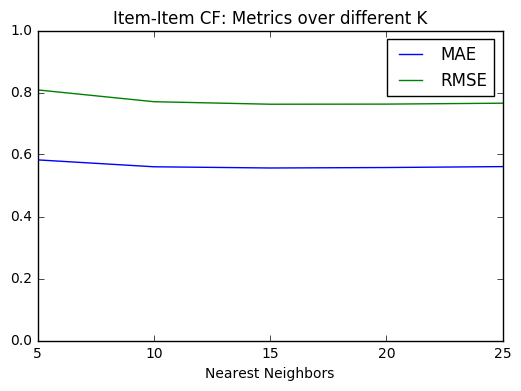

In [263]:
results_df1 = pd.DataFrame({'Nearest Neighbors': [5, 10, 15, 20, 25], 'MAE': each_sims, 'RMSE': each_sims_rmse })
plot1 = results_df1.plot(x='Nearest Neighbors', y=['MAE', 'RMSE'], ylim=(0,1), title = 'Item-Item CF: Metrics over different K')
fig = plot1.get_figure()
fig.savefig('MetricsCFK.png')

getmrec function is used to get top m recommendation for a user_id based on the similarity matrix (option), k neighbours.

In [264]:
full_mat = np.zeros((len(rows),len(cols)))
for row in nmat:
    full_mat[row[0], row[1]] = row[2]
#item_similarity, amean, umean, imean = itemsimilar(full_mat, 'euc')

In [265]:
def getmrec(full_mat, user_id, item_similarity, k, m, idict,  cov = False):
    
    n = item_similarity.shape[0]
    nzero = full_mat[user_id].nonzero()[0]
    
    preds = {}
    for row in range(n):
        preds[row] = predict(user_id, row, full_mat, item_similarity, amean, umean, imean, k)
    
    flipped_dict = dict(zip(idict.values(), idict.keys()))
    
    if not cov:
        print("Books Read -----")
        for i in nzero:
            print(flipped_dict[i])
            del preds[i]
    
    
    res = sorted(preds.items(), key=lambda x: x[1], reverse = True)
    
    ans = [flipped_dict[i[0]] for i in res[:m]]
    return ans

In [266]:
flipped_dict = dict(zip(idict.values(), idict.keys()))

In [267]:
def coverage(full_mat, user_id, item_similarity, k, mlist, flipped_dict,  cov = False):
    
    n = item_similarity.shape[0]
    nzero = full_mat[user_id].nonzero()[0]
    
    preds = {}
    for row in range(n):
        preds[row] = predict(user_id, row, full_mat, item_similarity, amean, umean, imean, k)
        
    if not cov:
        print("Books Read -----")
        for i in nzero:
            print(flipped_dict[i])
            del preds[i]
    
    
    res = sorted(preds.items(), key=lambda x: x[1], reverse = True)
    
    ret_tup = []
    ans = [flipped_dict[i[0]] for i in res[:mlist[-1]]]
    for i in mlist:
        ret_tup.append(ans[:i])
    
    return ret_tup

In [268]:
cov1 = []
cov2 = []
cov3 = []
cov4 = []
cov5 = []
mlist = [5,10,15,20,25]
for i in range(len(rows)):
    if(i%100 == 0):
        print(i)
    ans = coverage(full_mat, i, items, 10, mlist, flipped_dict, True)
    cov1.extend(ans[0])
    cov2.extend(ans[1])
    cov3.extend(ans[2])
    cov4.extend(ans[3])
    cov5.extend(ans[4])

0


/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in double_scalars


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000


### Coverage Results

In [269]:
print("Coverage with recommending 5 books", len(set(cov1))/4959 *100 ,"%")

Coverage with recommending 5 books 47.48941318814277 %


In [270]:
print("Coverage with recommending 10 books", len(set(cov2))/4959 *100 ,"%")

Coverage with recommending 10 books 66.76749344625932 %


In [271]:
print("Coverage with recommending 15 books", len(set(cov3))/4959 *100 ,"%")

Coverage with recommending 15 books 76.40653357531761 %


In [272]:
print("Coverage with recommending 20 books", len(set(cov4))/4959 *100 ,"%")

Coverage with recommending 20 books 82.03266787658802 %


In [273]:
print("Coverage with recommending 25 books", len(set(cov5))/4959 *100 ,"%")

Coverage with recommending 25 books 85.88425085702762 %


### Loading Book Features

In [274]:
feats = pd.read_csv('../book_features.csv')

In [275]:
feats.shape

(4959, 17)

In [276]:
feats.head()

,Unnamed: 0,Science_Score,Satire_Score,Drama_Score,Action_Score,Romance_Score,Mystery_Score,Horror_Score,Travel_Score,Children_Score,Religion_Score,History_Score,Biography_Score,Autobiography_Score,Fantasy_Score,isbn,title
0,0,0.038207,0.068504,0.069262,0.034280,0.067933,0.080699,0.093292,0.048437,0.067634,0.058378,0.065526,0.045191,0.044895,0.071272,0002007770,Water for Elephants
1,1,0.039468,0.075064,0.061319,0.055943,0.092886,0.093401,0.090650,0.063545,0.055523,0.064056,0.094257,0.073566,0.068922,0.071120,0002051850,For Whom the Bell Tolls
2,2,0.037345,0.061224,0.052370,0.034974,0.064670,0.076909,0.076948,0.040161,0.049419,0.057505,0.076696,0.031504,0.030831,0.060471,0002247399,"A Dance with Dragons (A Song of Ice and Fire, #5)"
3,3,0.040277,0.059965,0.056401,0.040376,0.068644,0.090155,0.089819,0.046808,0.054902,0.057387,0.068051,0.053922,0.046720,0.067391,0006476155,"Along Came a Spider (Alex Cross, #1)"
4,4,0.024843,0.050273,0.067219,0.023418,0.088785,0.081145,0.076581,0.041120,0.087698,0.046154,0.067406,0.054567,0.061165,0.064440,0006514006,The Other Boleyn Girl


In [277]:
scores = feats.iloc[:,1:15]

In [278]:
scores1 = scores.as_matrix()

In [279]:
scores1.shape

(4959, 14)

In [280]:
inputscores = scores1.T

In [284]:
naive = np.zeros((len(rows),len(cols)))
for row in x1:
    naive[row[0], row[1]] = row[2]
items_features, temple1, temple2, temple3 = itemsimilar(inputscores,'')

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in true_divide


In [285]:
get_results1(nmat, len(rows), len(cols), 5 ,20,items_features, amean,umean, imean)

----------   Fold  1 ---------------


/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in double_scalars


Train Errors
RMSE : 0.7892
MAE : 0.5834
Test Errors
RMSE : 0.8164
MAE : 0.6030
----------   Fold  2 ---------------
Train Errors
RMSE : 0.7919
MAE : 0.5855
Test Errors
RMSE : 0.8048
MAE : 0.5923
----------   Fold  3 ---------------
Train Errors
RMSE : 0.7929
MAE : 0.5861
Test Errors
RMSE : 0.8011
MAE : 0.5921
----------   Fold  4 ---------------
Train Errors
RMSE : 0.7929
MAE : 0.5859
Test Errors
RMSE : 0.8025
MAE : 0.5946
----------   Fold  5 ---------------
Train Errors
RMSE : 0.7926
MAE : 0.5860
Test Errors
RMSE : 0.8030
MAE : 0.5932
-------------------------------------
Training Avg Error:
AVG RMSE : 0.791927450548
AVG MAE : 0.585381915522

Testing Avg Error:
AVG RMSE : 0.805574805134
AVG MAE : 0.595045180631
 


(0.59504518063050416, 0.80557480513416713)

In [287]:
each_sims_con = []
each_sims_rmse_con = []
for k in [5, 10, 15, 20, 25]:
    print("Nearest Neighbors: ",k)
    ans1, ans2  = get_results1(nmat, len(rows), len(cols), 5 ,k,items_features, amean,umean, imean)
    each_sims_con.append(ans1)
    each_sims_rmse_con.append(ans2)

print()
print("Best K Value for")
print()
print("Min MAE")
print(np.min(each_sims_con), np.argmin(each_sims_con))
print("Min RMSE")
print(np.min(each_sims_rmse_con), np.argmin(each_sims_rmse_con))
print()
    

Nearest Neighbors:  5
----------   Fold  1 ---------------


/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in double_scalars


Train Errors
RMSE : 0.8301
MAE : 0.6046
Test Errors
RMSE : 0.8606
MAE : 0.6289
----------   Fold  2 ---------------
Train Errors
RMSE : 0.8317
MAE : 0.6063
Test Errors
RMSE : 0.8532
MAE : 0.6202
----------   Fold  3 ---------------
Train Errors
RMSE : 0.8336
MAE : 0.6076
Test Errors
RMSE : 0.8470
MAE : 0.6182
----------   Fold  4 ---------------
Train Errors
RMSE : 0.8332
MAE : 0.6069
Test Errors
RMSE : 0.8467
MAE : 0.6187
----------   Fold  5 ---------------
Train Errors
RMSE : 0.8351
MAE : 0.6085
Test Errors
RMSE : 0.8495
MAE : 0.6204
-------------------------------------
Training Avg Error:
AVG RMSE : 0.832729392494
AVG MAE : 0.606799104198

Testing Avg Error:
AVG RMSE : 0.851395324026
AVG MAE : 0.621298062042
 
Nearest Neighbors:  10
----------   Fold  1 ---------------
Train Errors
RMSE : 0.8011
MAE : 0.5893
Test Errors
RMSE : 0.8303
MAE : 0.6108
----------   Fold  2 ---------------
Train Errors
RMSE : 0.8037
MAE : 0.5912
Test Errors
RMSE : 0.8198
MAE : 0.6007
----------   Fold  3